# Gaussian Regression Colors

This notebook uses Gaussian regression to fit CSP light curves and model the evolution of observed color over time. Results are compared to the color evolution of individual models.


In [1]:
import sys
from copy import deepcopy

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from sndata.csp import dr3

sys.path.insert(0, '../')
from analysis import models
from analysis import lc_colors


In [2]:
# Register models and data with sncosmo
models.register_sources(force=True)
dr3.download_module_data()
dr3.register_filters(force=True)

# Pick a CSP target to use in demo plots
demo_id = '2005kc'

# Load various SN models
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))

# Add an extinction component to each model
# The extinction component is zero until changed
model_list = [m102, m104, m14, m17, salt2]
for model in model_list:
    model.add_effect(sncosmo.F99Dust(), 'ext', 'rest')


## Transmission Filters

We review the CSP filter transmission curves and take note that there are multiple "duplicate" filters where different physical filters were used on different telescopes or a filter was broken and subsequently replaced.

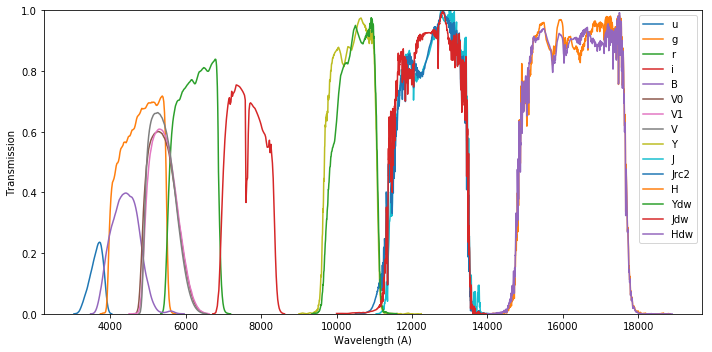

In [3]:
plt.figure(figsize=(10, 5))
for band_name in dr3.band_names:
    band = sncosmo.get_bandpass(band_name)
    band_label = band_name.split('_')[-1]
    
    plt.plot(band.wave, band.trans, label=band_label)
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Transmission')

plt.legend()  
plt.ylim(0, 1)
plt.tight_layout()


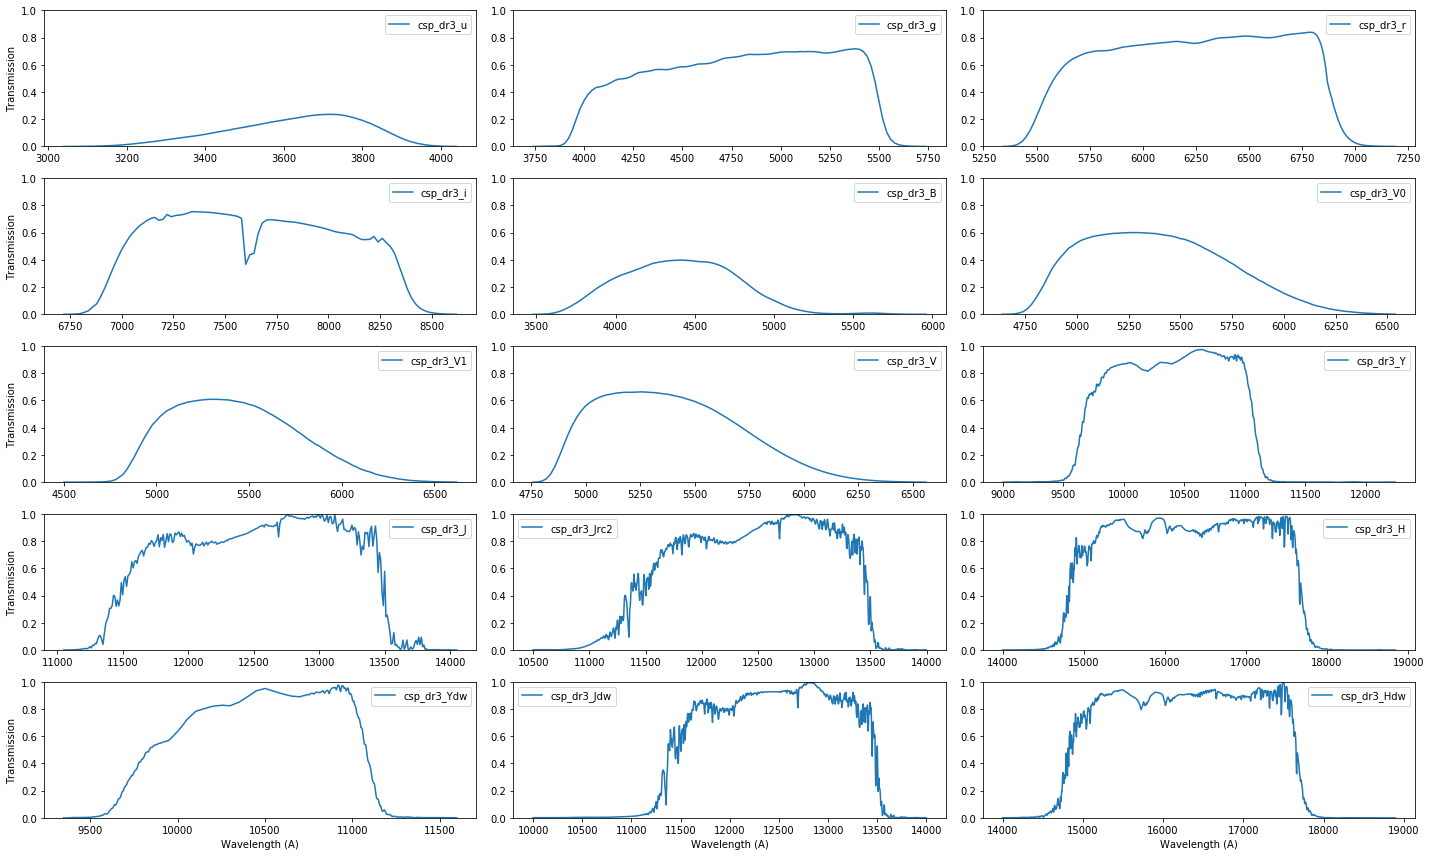

In [4]:
columns = 3
scale_factor = 4

rows = int(np.ceil(len(dr3.band_names) / columns))
fig_shape = (rows, columns)
fig_size = (scale_factor * rows, scale_factor * columns)

fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
for band_name, axis in zip(dr3.band_names, axes.flatten()):
    band = sncosmo.get_bandpass(band_name)
    axis.plot(band.wave, band.trans, label=band_name)
    axis.set_ylim(0, 1)
    axis.legend()
    
for axis in axes[4, :]:
    axis.set_xlabel('Wavelength (A)')

for axis in axes[:, 0]:
    axis.set_ylabel('Transmission')
    
plt.tight_layout()


For simplicity, we define a set of fiducial band passes with unique effective wavelengths.

In [5]:
unique_bands = np.array([
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V',
    'csp_dr3_Y',
    'csp_dr3_H',
    'csp_dr3_J'
])

color_combos = [(unique_bands[i], unique_bands[i + 1]) for i in range(len(unique_bands) - 1)]


## CMFGEN Color Evolution

To develop intuition, we compare of CMFGEN color evolution against Salt2.4. We recognize that the color evolution is dependent on the salt2 model parameters. However, we only concern ourselves with a fiducial model having the default parameters.


In [6]:
def legend_without_duplicate_labels(ax):
    """Add a legend to a figure axis that only has unique labels
    
    Args:
        ax (axis): A matplotlib axis
    """

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


def subplot_model_colors(model, band_combos, axes, **kwargs):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        model                  (Model): Model to calculate color with
        band_combos (list[tuple[str]]): Band combos to calculate color for
        axes                   (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """
    
    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    if len(axis_list) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    time = np.arange(model.mintime(), model.maxtime())
    t0 = model.source.peakphase('standard::b')
    for (band1, band2), axis in zip(band_combos, axis_list):
        try:
            c = model.color(band1, band2, 'ab', time)
            
        except ValueError as e:
            print(f'{model.source.name} {model.source.version}: {e}')
            pass

        else:
            label = f'{model.source.name} {model.source.version}'
            axis.plot(time - t0, c, label=label, **kwargs)
            
            y_label = f'{band1.split("_")[-1]} - {band2.split("_")[-1]}'
            axis.set_ylabel(y_label)
            axis.set_xlabel('Time')
            legend_without_duplicate_labels(axis)


def plot_model_colors(models, bands):
    """Plot model colors for a given collection of models and bandpasses
    
    Args:
        models (list[Model]): Models to calculate color with
        bands    (list[str]): Bands to calculate color for
    """
    
    band_combos = [(bands[i], bands[i + 1])for i in range(len(bands) - 1)]
    
    columns = 3
    rows = int(np.ceil(len(band_combos) / columns))
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 4 * columns)
    
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for model in models:
        subplot_model_colors(model, band_combos, axes)
        
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.tight_layout()
    return fig, axes


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:1528: RuntimeWarning: invalid value encountered in subtract
  self.bandmag(band2, magsys, time))


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2000, .., 9200]


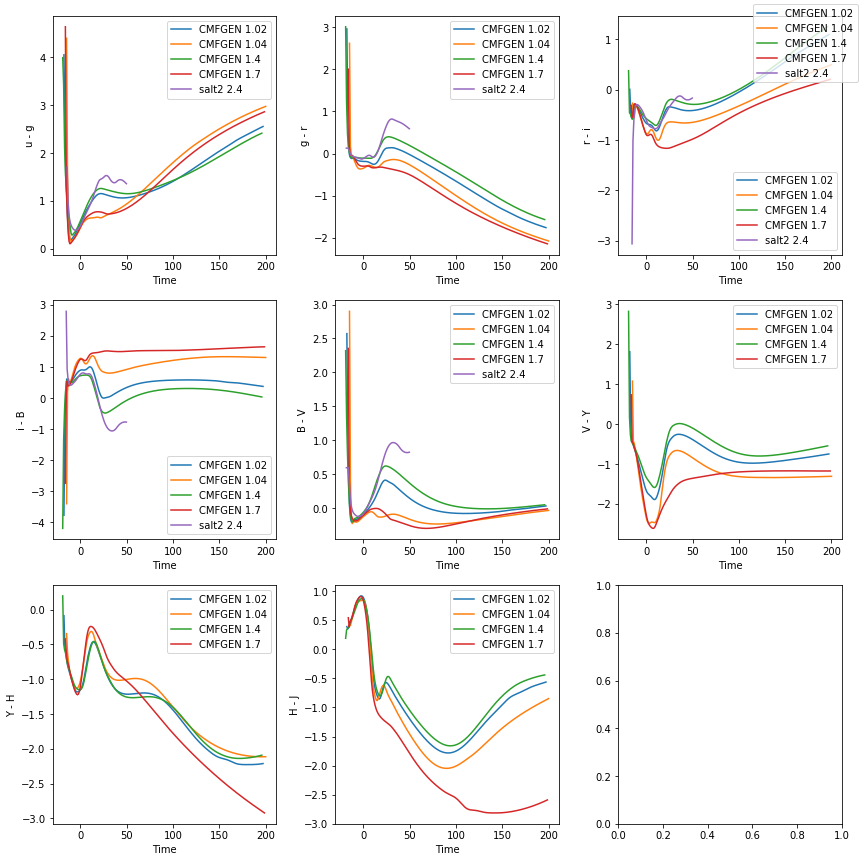

In [7]:
for model in model_list: 
    model.set(extebv=0)
    subplot_model_colors(model, color_combos, axes)

fig, axes = plot_model_colors(model_list, unique_bands)


# Gaussian Regression

We use Gaussian regression to fit the light curves in each band and determine the color evolution as a function of time.


In [8]:
def plot_regression(data, time, bands, pred_flux, pred_unc):
    """Plot regression results
    
    Args:
        data            (Table): The measured photometric data
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertainty from the regression
    
    Returns:
        The figure object
        An array of figure axes
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 8 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for axis in axes[rows - 1]:
        axis.set_xlabel('Time')
        
    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')
        
    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        band_data = data[data['band'] == band_name]
        axis.scatter(band_data['time'], band_data['flux'], label=band_name)
        axis.errorbar(band_data['time'], band_data['flux'], band_data['fluxerr'], linestyle='', label=None)
        axis.plot(time, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            time, 
            f - fe, 
            f + fe, 
            alpha=.3, 
            color='grey',
            label='Regression Error'
        )
        
        axis.set_xlim(min(time), max(time))
        axis.legend()

    plt.tight_layout()
    return fig, axes


def subplot_sncosmo_fit(time, bands, fitted_model, axes):
    """
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = fitted_model.bandflux(band, time)
        
        except ValueError as e:
            print(f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass
        
        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: csp_dr3_H, csp_dr3_J, csp_dr3_Y(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]


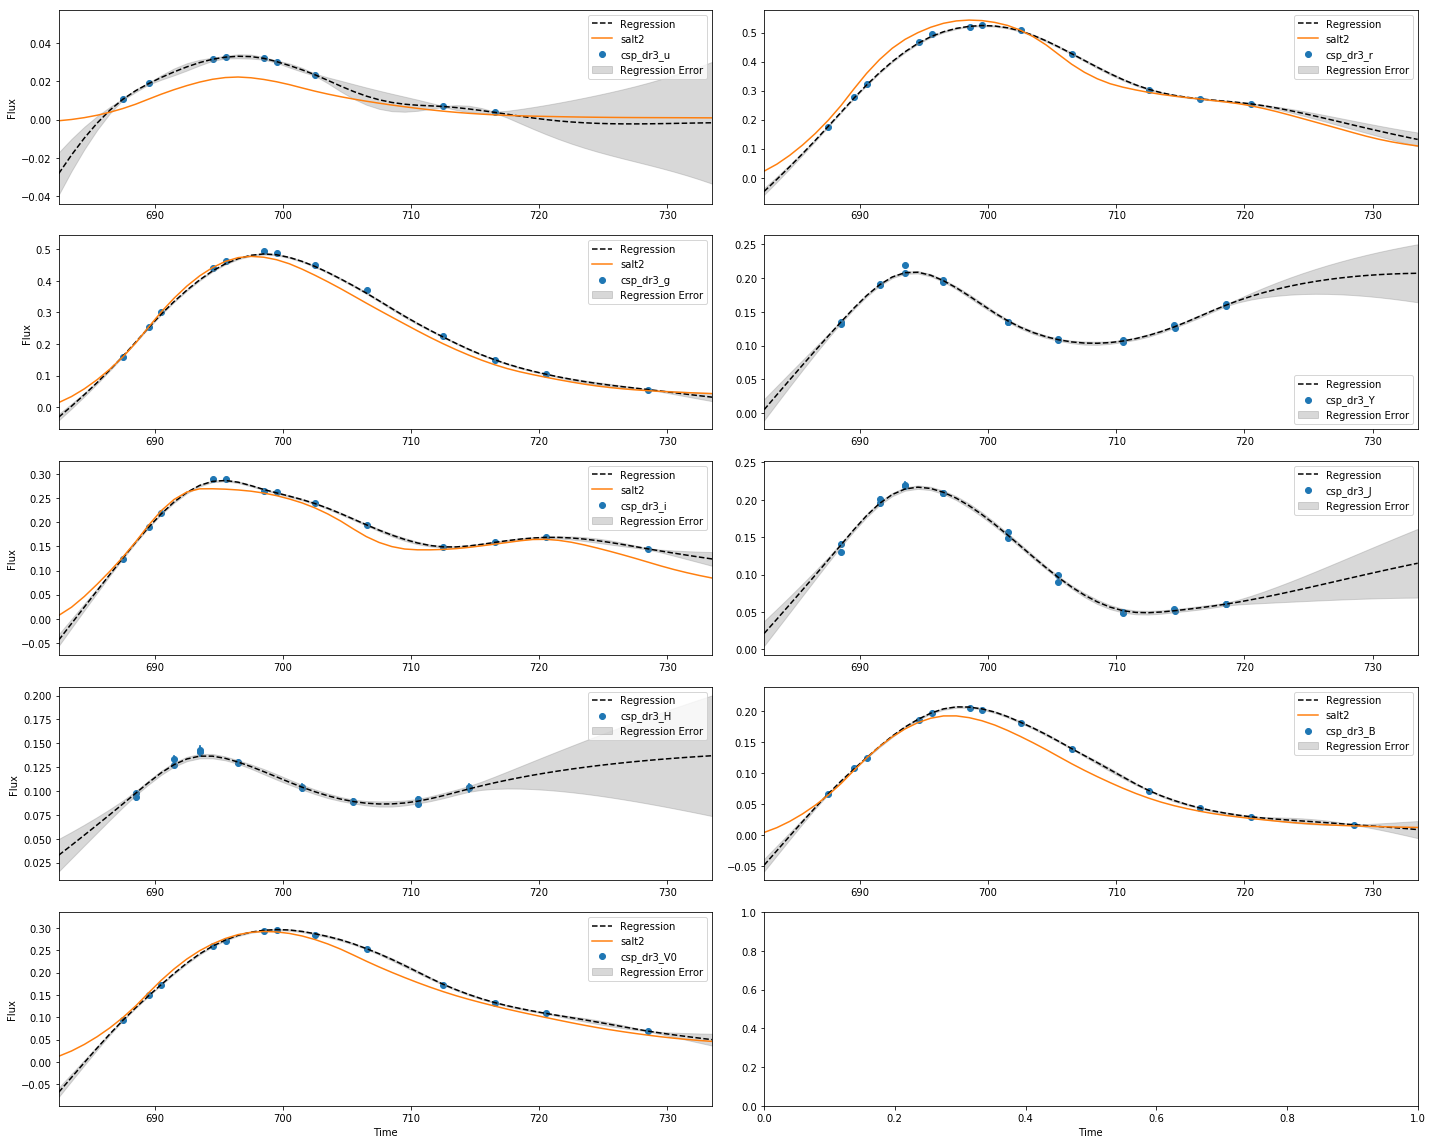

In [9]:
# Fit a gaussian regression
data_table = dr3.get_data_for_id(demo_id, format_sncosmo=True)
gp = lc_colors.fit_gaussian_process(data_table)

# Fit salt2
salt2_model = deepcopy(salt2)
salt2_model.set(z=data_table.meta['redshift'])
salt2_model.set(t0=lc_colors.get_csp_t0(demo_id))
fit_result, fitted_model = sncosmo.fit_lc(data_table, salt2_model, ['x0', 'x1', 'c'])

# Plot modeled flux
bands = set(data_table['band'])
time = np.arange(min(data_table['time']) - 5, max(data_table['time']) + 5)
pred_flux, pred_unc = lc_colors.predict_light_curve(gp, bands, time)
fig, axes = plot_regression(data_table, time, bands, pred_flux, pred_unc)
subplot_sncosmo_fit(time, bands, fitted_model, axes)


## Comparing Gaussian and Modeled Colors

We compare the gaussian fit color evolution against the CMFGEN models. In order to align the time scales of all results, we use the published `t0` (Salt2) value from CSP to shift the gaussian regressions to the correct t = 0 point.

In [10]:
def subplot_regression_color(data, band_combos, axes, **kwargs):
    """Plot regressed colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        gp            (GP): A fitted gaussian process
        t0         (float): Time of B max for the fitted target
        band_combos (list): List of tuples with two bandpass names
        axes       (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    if len(axes.flatten()) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    gp = lc_colors.fit_gaussian_process(data)
    t0 = lc_colors.get_csp_t0(data.meta['obj_id'])
    band_times = lc_colors.get_color_times(data, band_combos)
    colors = lc_colors.predict_colors(gp, band_combos, band_times)

    plot_data = zip(band_times, colors, axes.flatten())
    for time, color, axis in plot_data:
        axis.plot(time - t0, color, label='Regression', **kwargs)
        legend_without_duplicate_labels(axis)


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:1528: RuntimeWarning: invalid value encountered in subtract
  self.bandmag(band2, magsys, time))


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2000, .., 9200]


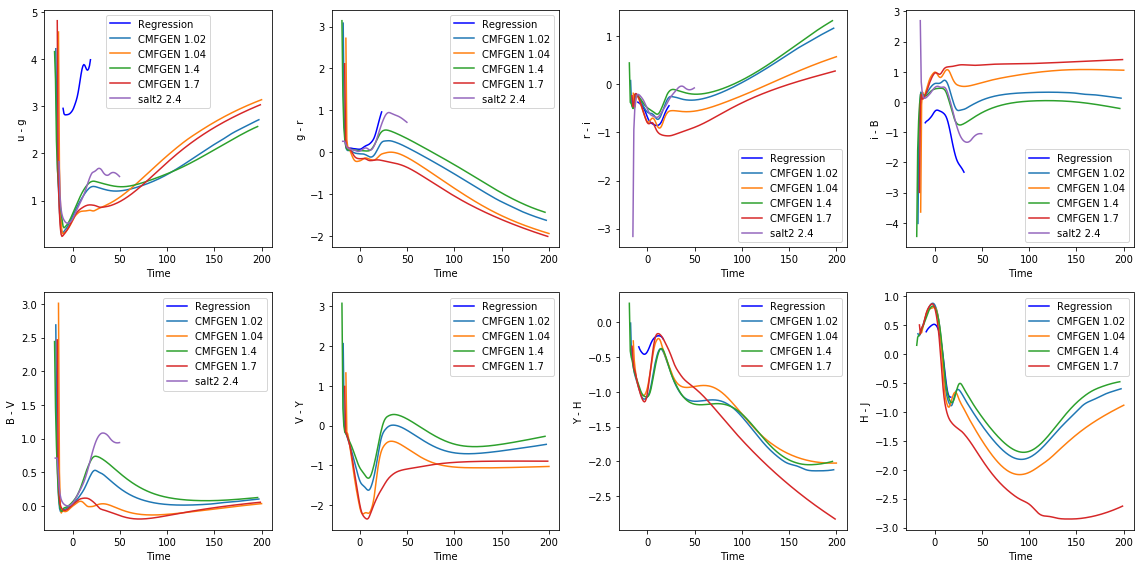

In [11]:
fig_shape = (2, 4)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
subplot_regression_color(data_table, color_combos, axes, color='blue')

for model in model_list: 
    model.set(extebv=lc_colors.get_csp_ebv(demo_id))
    subplot_model_colors(model, color_combos, axes)

axes[-1][-1].legend()
plt.tight_layout()


## $\chi^2$ Calculation

  0%|          | 0/134 [00:00<?, ?it/s]

NameError: name 'get_csp_t0' is not defined

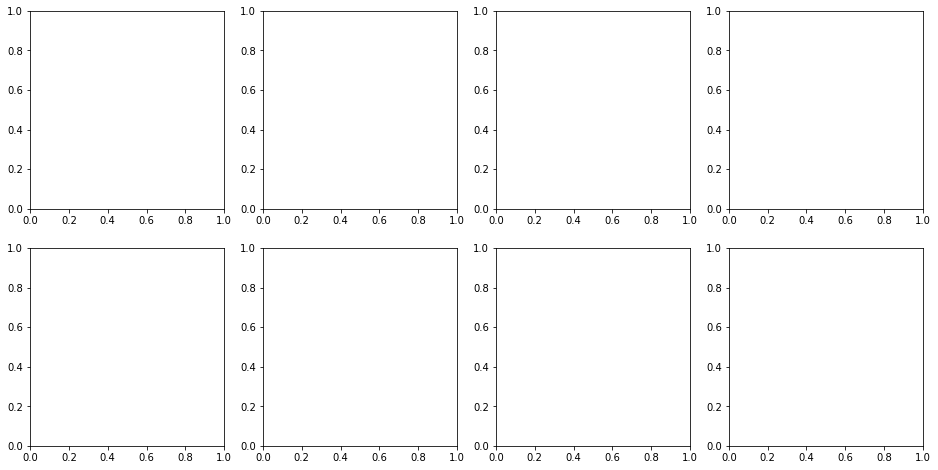

In [12]:
def filter_func(data):
    """Return whether a target has a CSP publishd t0
    
    Args:
        data (Table): An table returned by sndata
        
    Returns:
        A boolean
    """

    try:
        get_csp_t0(data.meta['obj_id'])
        return True

    except ValueError:
        return False


band_combos = [(unique_bands[i], unique_bands[i + 1]) for i in range(len(unique_bands) - 1)]
    
fig_shape = (2, 4)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)

for data_table in dr3.iter_data(filter_func=filter_func, format_sncosmo=True, verbose=True):
    subplot_regression_color(data_table, band_combos, fig, axes, color='grey', alpha=.5)

for model in models:
    subplot_model_colors(model, band_combos, fig, axes)

plt.tight_layout()
